In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
from functional import seq
from tqdm.auto import tqdm

from utils import process_viztrace_json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')

## Reading and parsing data

In [3]:
# df_mems = []
# for file in tqdm(sorted(Path('benchmark_jsons').glob('*.json'))):
#     try:
#         df_mem, df_info = process_viztrace_json(file)
#         df_mem[["toolkit", "index", "nb_traces", "n", "n_out", "headless"]] = (
#             seq(file.name.split(".")[0].split("__"))
#                 .map(lambda x: x.split("=")[-1])
#                 .to_list()
#         )
#         df_mem[['index', 'nb_traces', 'n', 'n_out']] = df_mem[
#             ['index', 'nb_traces', 'n', 'n_out']].astype(int)
#         df_mem.loc[:df_info[df_info.name.str.contains('constructed image')].index[0],
#         'phase'] = 'image construction'
#         df_mem.loc[df_info[df_info.name.str.contains('constructed image')].index[0]:,
#         'phase'] = 'rendering'
#         df_mems.append(df_mem.reset_index())
#     except Exception as e:
#         print(file)
#         print(e)

In [4]:
# df_mem_tot = pd.concat(df_mems, ignore_index=True)
# df_mem_tot['args.rss'] /= 1e6
# df_mem_tot.rename(columns={'args.rss': 'memory (MB)'}, inplace=True)
# df_mem_tot['ts'] = df_mem_tot.ts.dt.total_seconds()
# df_mem_tot.rename(columns={'ts': 'duration (s)'}, inplace=True)
# df_mem_tot = pd.concat([df_mem_tot, pd.read_parquet('df_mem_tot.parquet', engine='fastparquet')], ignore_index=True)
# df_mem_tot['n'] = df_mem_tot['n'].map(lambda x: f'{x:,}')

In [8]:
df_mem_tot = pd.read_parquet('df_mem_tot_r.parquet')
df_mem_tot['n'] = df_mem_tot['n'].map(lambda x: f'{x:,}')

In [9]:
df_mem_viz = (
    df_mem_tot.groupby(["toolkit", "index", "nb_traces", 'n'])[["duration (s)", "memory (MB)"]]
        .max()
        .reset_index()
)

## The visualization

The visualization below uses a limited amount of traces (more realistic use-case)

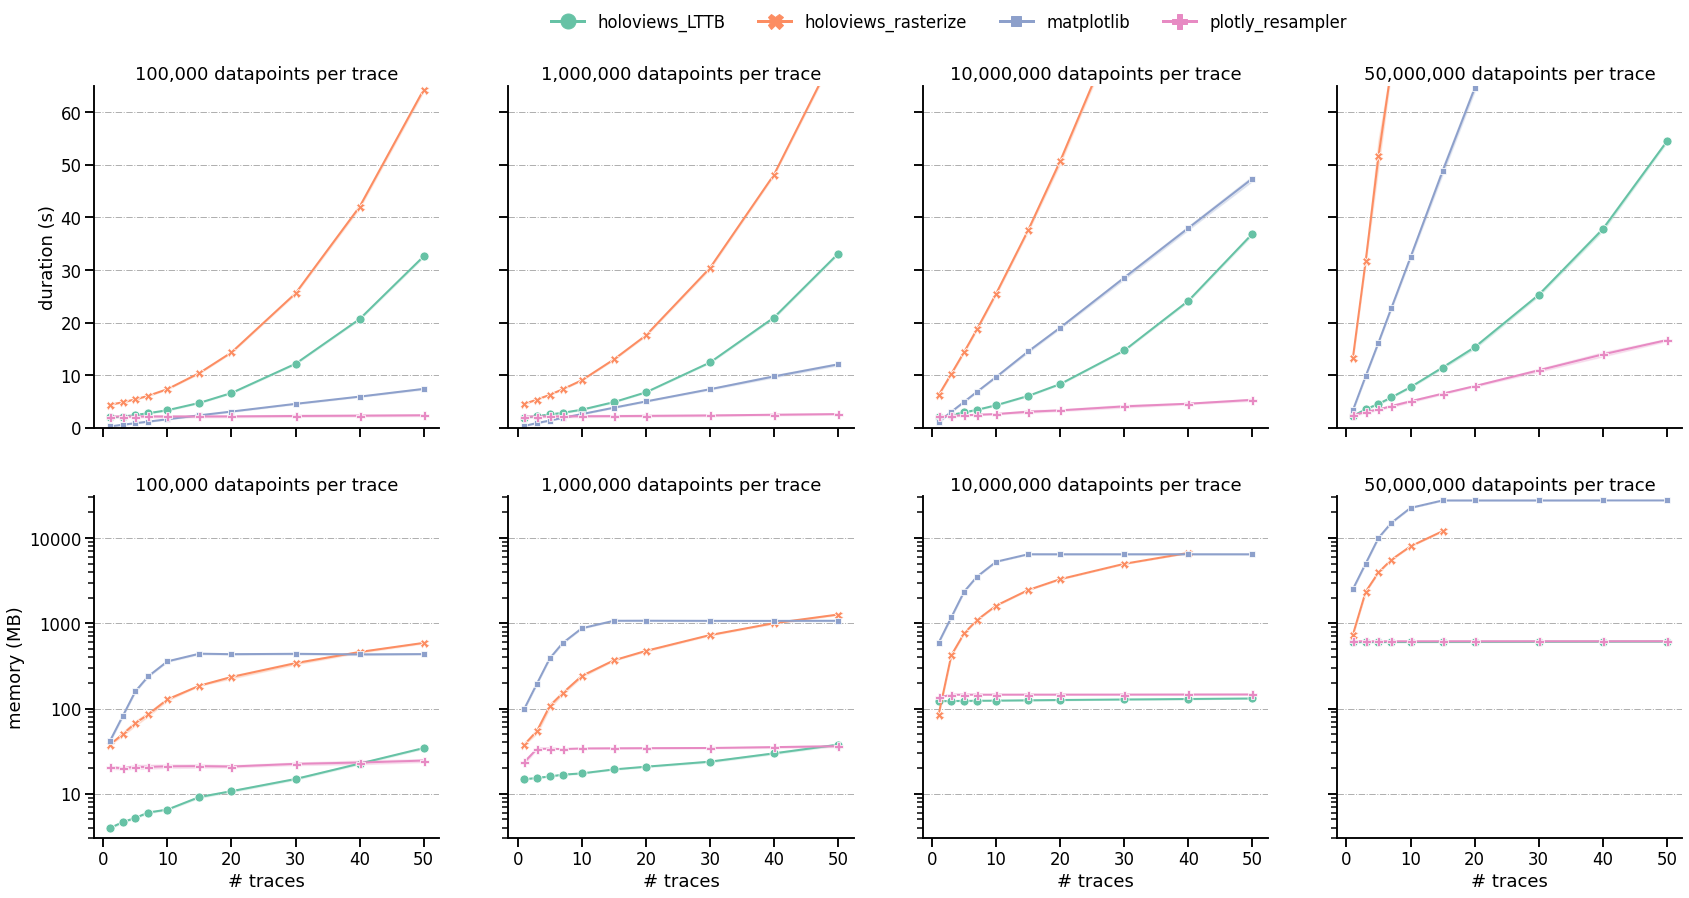

In [10]:
row_order = ["duration (s)", "memory (MB)"]
g = sns.relplot(
    data=df_mem_viz[df_mem_viz.nb_traces.isin([1, 3, 5, 7, 10, 15, 20, 30, 40, 50])]
    .melt(id_vars=["nb_traces", "toolkit", "index", "n"])
    .rename(
        columns={
            "nb_traces": "# traces",
            "n": "datapoints per trace",
        }
    ),
    kind="line",
    hue="toolkit",
    style="toolkit",
    x="# traces",
    row="variable",
    y="value",
    markers=True,
    dashes=False,
    height=6,
    palette="Set2",
    linewidth=2,
    col="datapoints per trace",
    col_order=["100,000", "1,000,000", "10,000,000", "50,000,000"],
    row_order=row_order,
    facet_kws={"sharey": "row"},  #'sharex': 'row'}
)

g.set_titles("{col_name} {col_var}")
for ax in g.axes[0]:
    ax.set_ylim(0, 65)
    ax.grid(True, axis="y", linewidth=1, linestyle="dashdot")


for ax, y_range, ticks in zip(
    g.axes[1],
    [(3, 650), (9, 1450), (70, 7000), (500, 31000)],
    [
        [5, 10, 50, 100, 500],
        [10, 50, 100, 500, 1000],
        [100, 500, 1000, 5000],
        [500, 1000, 5000, 10000, 20000],
    ],
):
    # ax.set_ylim(y_range[0], y_range[1])
    ax.grid(True, axis="y", linewidth=1, linestyle="dashdot")
    ax.set_ylim(3, 31_000)
    ax.set_yscale("log")
    ax.set_yticks([10, 100, 1000, 10_000])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

sns.move_legend(
    g, "lower center", bbox_to_anchor=(0.5, 1), ncol=4, title=None, frameon=False
)
plt.setp(g.legend.get_lines(), linewidth=3, markersize=15)

for row_axs, row_name in zip(g.axes, row_order):
    row_axs[0].set_ylabel(row_name)
plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [11]:
g.savefig('../reports/benchmark_fig.png', dpi=250)

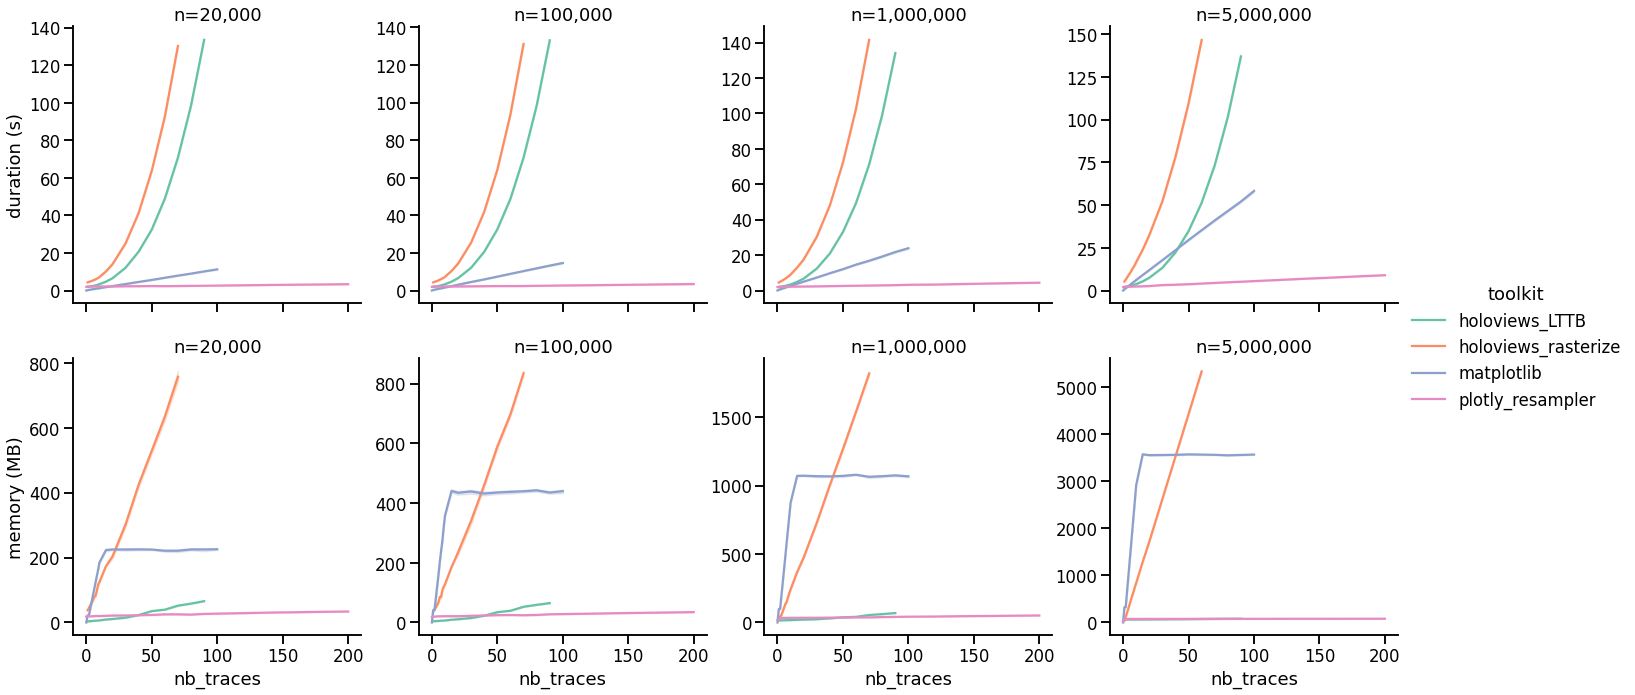

In [12]:
row_order = ['duration (s)', 'memory (MB)']
g = sns.relplot(
    data=df_mem_viz.melt(id_vars=['nb_traces', 'toolkit', 'index', 'n']),
    kind='line',
    hue='toolkit',
    x='nb_traces',
    y='value',
    row='variable',
    height=5,
    palette='Set2',
    col='n',
    col_order=['20,000', '100,000', '1,000,000', '5,000,000'],
    row_order=row_order,
    facet_kws={'sharey': False} #'sharex': 'row'}
)
g.set_titles("{col_var}={col_name}")
for row_axs, row_name in zip(g.axes, row_order):
    row_axs[0].set_ylabel(row_name)
plt.subplots_adjust(wspace=0.2, hspace=0.2)